# Itération 3

## Intitulé de l'itération

### age	height	weight	duration	heart_rate	body_temp

### Label enconder

### Régression linéaire

### Plot des prédiction par rapport au train sur toutes les features

### Learning curve

## Import

In [1]:
import os
import psycopg2
from dotenv import load_dotenv

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
plt.style.use('seaborn')

# Affichage cellule
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_row', 1000)
from pprint import pprint

# Chargement du model pour déploiement
import pickle

## Connection à la DB sécurisé via des variables d'environnement

### création de la chaine de connexion

In [2]:


load_dotenv()  # Nécessaire pour charger les variables d'environnement précédemment définies

# Créer une connexion à postgres
connection = psycopg2.connect(host=os.environ.get('PG_HOST'),
                        user=os.environ.get('PG_USER'),
                        password=os.environ.get('PG_PASSWORD'),
                        dbname=os.environ.get('PG_DATABASE'))

connection.autocommit = True  # Assurez-vous que les données sont ajoutées à la base de données immédiatement après les commandes d'écriture.
cursor = connection.cursor()
cursor.execute('SELECT %s as connected;', ('Connection à postgres Réussie!',))
print(cursor.fetchone())

('Connection à postgres Réussie!',)


### Fonction de création du dataframe

In [3]:
def postgresql_to_dataframe(conn, select_query, column_names):
    """
    Transformer une requête SELECT en un dataframe pandas
    """
    cursor = conn.cursor()
    try:
        cursor.execute(select_query)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return 1
    
    # Naturellement, nous obtenons une liste de "tupples".
    tupples = cursor.fetchall()
    cursor.close()
    
    # Nous devons juste le transformer en dataframe pandas.
    df = pd.DataFrame(tupples, columns=column_names)
    return df

### Récupération de postgresql au dataframe

In [4]:
conn = connection
column_names = ["user_id","gender", "age", "height", "weight", "duration", "heart_rate", "body_temp", "calorie"]
# Execute the "SELECT *" query
df_db = postgresql_to_dataframe(conn, 
"SELECT persons.user_id as id, gender, age, height, weight, duration, heart_rate, body_temp,calorie FROM calories INNER JOIN persons ON calories.user_id = persons.user_id"
                                , column_names)
df_db.head()

,user_id,gender,age,height,weight,duration,heart_rate,body_temp,calorie
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


In [5]:
df_db.shape

(15000, 9)

## Modele

In [6]:
# utilisation des doubles crochets pour renvoyer un DataFrame pour la variable  X
X = df_db[['age', 'height', 'weight', 'duration', 'heart_rate', 'body_temp']]
# y unidimensionnel
y = df_db['calorie']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=10)

In [7]:
X.head(1)

,age,height,weight,duration,heart_rate,body_temp
0,68,190.0,94.0,29.0,105.0,40.8


### Régression linéairee mutilple

In [8]:
model_lineaire = LinearRegression()
model_lineaire.fit(X_train,y_train)

X_train.head(1)

,age,height,weight,duration,heart_rate,body_temp
7380,45,173.0,73.0,14.0,99.0,40.2


#### Score

In [9]:
model_lineaire.score(X_test,y_test)

0.9668917868828775

#### Graphique représentant la prédiction des calories a partir du jeu d'entrainement

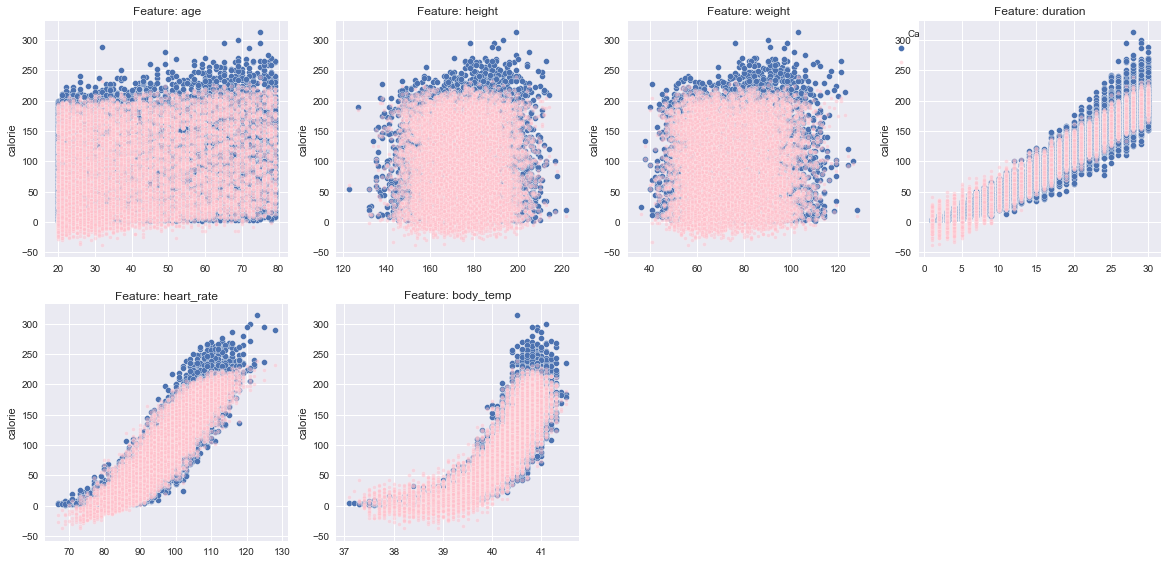

In [10]:
# Calories prédit à partir de xtrain
ypred_train = model_lineaire.predict(X_train)

# créer la figure
fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(20, 20))

# aplatir les axes pour faciliter leur indexation
axes = axes.flatten()

# itérer à travers les valeurs des colonnes, et utiliser i pour indexer les axes
for i, v in enumerate(X_train.columns):
    
    # sélectionner la colonne à tracer
    data = X_train[v]
    
    # Tracez les calories réel en fonction des caractéristiques
    axes[i].scatter(x=data, y=y_train, s=35, ec='white', label='actual')
    
    # Tracer les calories prédites en fonction des caractéristiques
    axes[i].scatter(x=data, y=ypred_train, c='pink', s=15, ec='white', alpha=0.5, label='predicted')

    # définir le titre et l'étiquette y
    axes[i].set(title=f'Feature: {v}', ylabel='calorie')

# definir une legende
axes[2].legend(title='Calories', bbox_to_anchor=(1.05, 1), loc='upper left')

# supprimez les axes inutilisés
for v in range(6, 16):
    fig.delaxes(axes[v])

#### Courbe d'apprentissage

##### entrainement et cross val score

In [11]:
train_sizes, train_scores, test_scores = learning_curve(model_lineaire, X, y, cv=10, scoring='r2', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))

In [12]:
#train_scores

##### Calcul des métriques

In [13]:
# Nous allons maintenant calculé la moyenne et l'écart-type des scores d'entraînement et de test.
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

In [14]:
#train_sizes

In [15]:
#train_mean

##### Tracer la courbe d'apprentissage avec R2

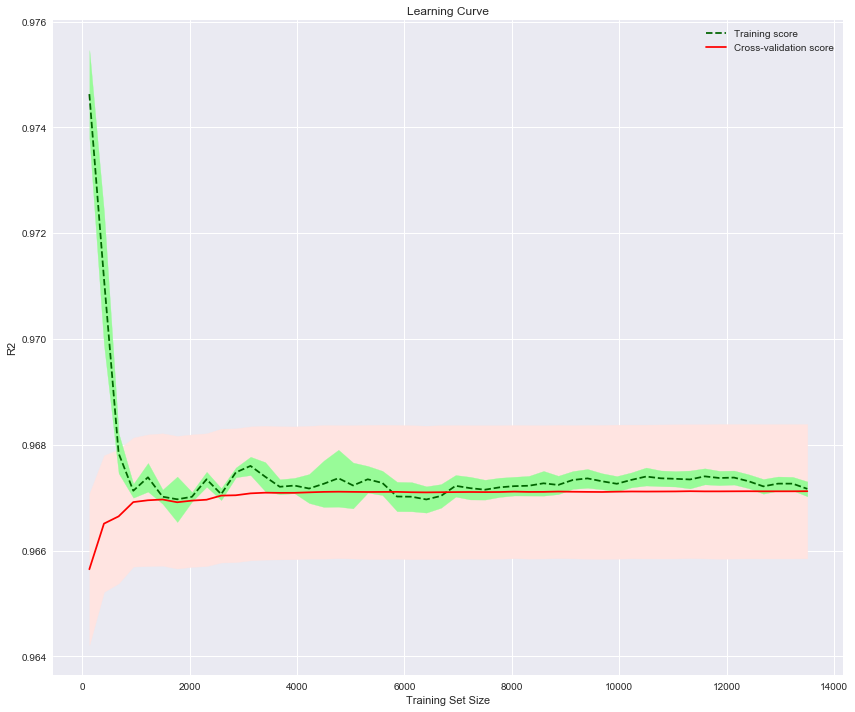

In [16]:
plt.subplots(1, figsize=(12,10))
plt.plot(train_sizes, train_mean, '--', color="darkgreen",  label="Training score")
plt.plot(train_sizes, test_mean, color="red", label="Cross-validation score")

plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="mistyrose")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="palegreen")

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("R2"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

## Pickle

### Créer un objet itérateur avec droit d'écriture - model.pkl

In [17]:
with open('model/Regression_linéaire_6_features_pkl', 'wb') as files:
    pickle.dump(model_lineaire, files)

In [20]:
prediction_test = model_lineaire.predict([['38', '182', '80', '30', '122', '40']])

In [21]:
prediction_test

array([236.58030778])